In [1]:
#importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

from scipy.io import loadmat
import earthpy.plot as ep
import earthpy.spatial as es

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error

C:\Users\Sobhan\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
#loading datasets
X = loadmat("PaviaU.mat")["paviaU"]
y = loadmat("PaviaU_gt.mat")["paviaU_gt"]

In [3]:
#shape of the dataset
X.shape, y.shape

((610, 340, 103), (610, 340))

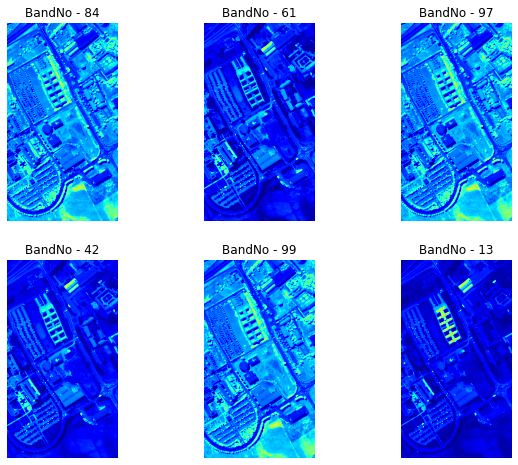

In [4]:
#plotting the bands
fig = plt.figure(figsize = (10, 8))
for i in range(1, 7):
    fig.add_subplot(2,3, i)
    q = np.random.randint(X.shape[2])
    plt.imshow(X[:,:,q], cmap = "jet")
    plt.axis("off")
    plt.title(f"BandNo - {q}")

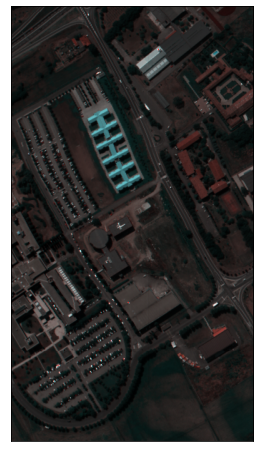

In [5]:
mdata = np.moveaxis(X, -1, 0)

ep.plot_rgb(mdata, (60, 30, 27), figsize = (10, 8)) 

plt.show()

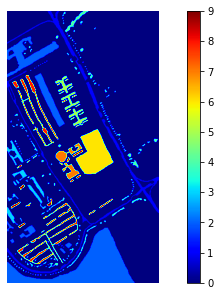

In [6]:
#visualizing groundtruth
def plot_data(X):
    fig = plt.figure(figsize = (10, 5))
    plt.imshow(X, cmap = "jet")
    plt.colorbar()
    plt.axis("off")
    plt.show()

plot_data(y)

In [7]:
#extracting the pixels
def extract_pixels(X,y):
    
    data = X.reshape(-1, X.shape[2])
    pavia = pd.DataFrame(data = data)
    pavia = pd.concat([pavia, pd.DataFrame(data = y.ravel())], axis = 1)
    pavia.columns= [f"band{i}" for i in range(1, 1+X.shape[2])] + ["class"]
    pavia.to_csv("pavia.csv")
    return pavia

pavia = extract_pixels(X, y)  

In [8]:
pavia.head()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band95,band96,band97,band98,band99,band100,band101,band102,band103,class
0,647,499,464,371,291,319,365,322,296,305,...,3416,3335,3256,3226,3205,3210,3221,3238,3250,0
1,604,546,527,455,378,377,336,314,324,329,...,2583,2538,2509,2511,2501,2468,2442,2464,2528,0
2,621,746,556,360,285,300,274,276,332,319,...,2288,2242,2193,2202,2225,2266,2308,2345,2361,0
3,637,592,482,556,508,284,178,198,193,224,...,2675,2609,2541,2551,2571,2569,2573,2620,2644,0
4,625,560,480,360,377,341,264,208,231,266,...,2392,2344,2289,2328,2415,2424,2386,2431,2456,0


In [9]:
pavia.shape

(207400, 104)

In [10]:
pavia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207400 entries, 0 to 207399
Columns: 104 entries, band1 to class
dtypes: uint16(103), uint8(1)
memory usage: 40.9 MB


In [11]:
pavia.isnull().sum()

band1      0
band2      0
band3      0
band4      0
band5      0
          ..
band100    0
band101    0
band102    0
band103    0
class      0
Length: 104, dtype: int64

In [12]:
pavia.duplicated().sum()

0

In [13]:
pavia.describe()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band95,band96,band97,band98,band99,band100,band101,band102,band103,class
count,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,...,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000
mean,925.324995,850.237584,800.363558,809.889783,830.085950,834.162700,833.530641,825.932729,823.827637,830.388689,...,2266.693293,2257.763443,2249.329595,2246.216779,2238.254364,2231.822647,2224.744884,2236.901707,2253.451692,0.707184
std,444.427499,468.464292,493.590158,527.235307,555.419089,574.543548,592.474167,605.782075,619.492506,636.532214,...,863.351557,857.286520,845.571285,833.001117,826.922155,827.403828,827.257369,834.092348,844.165146,1.753377
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,145.000000,146.000000,150.000000,140.000000,0.000000,134.000000,0.000000,0.000000
25%,649.000000,555.000000,483.000000,473.000000,480.000000,474.000000,461.000000,444.000000,433.000000,430.000000,...,1699.000000,1693.000000,1690.000000,1696.000000,1692.000000,1685.000000,1675.000000,1682.000000,1692.000000,0.000000
50%,857.000000,762.000000,694.000000,690.000000,693.000000,681.000000,671.000000,661.000000,657.000000,658.000000,...,2252.000000,2244.000000,2236.000000,2238.000000,2235.000000,2231.000000,2226.000000,2244.000000,2261.000000,0.000000
75%,1111.000000,1046.000000,1015.000000,1036.000000,1058.000000,1066.000000,1068.000000,1064.000000,1066.000000,1080.000000,...,2730.000000,2721.000000,2711.000000,2701.000000,2688.000000,2683.000000,2677.000000,2692.000000,2715.000000,0.000000
max,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,...,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,9.000000


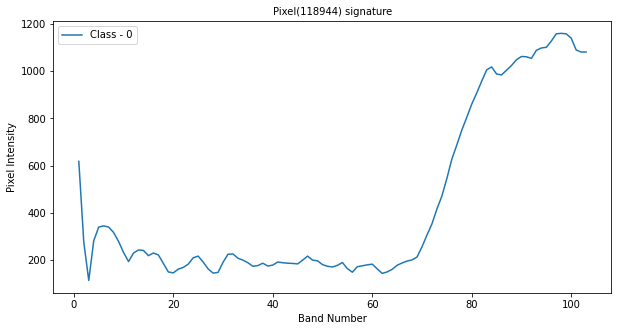

In [14]:
#visualizing spectral signatures

def plot_signature(pavia):
    plt.figure(figsize = (10, 5))
    pixel_no = np.random.randint(pavia.shape[0])
    plt.plot(range(1, 104), pavia.iloc[pixel_no, :-1].values.tolist(), label = f"Class - {pavia.iloc[pixel_no, -1]}")
    plt.legend()
    plt.title(f"Pixel({pixel_no}) signature", fontsize = 10)
    plt.xlabel("Band Number", fontsize = 10)
    plt.ylabel("Pixel Intensity", fontsize = 10)
    plt.show()

plot_signature(pavia)

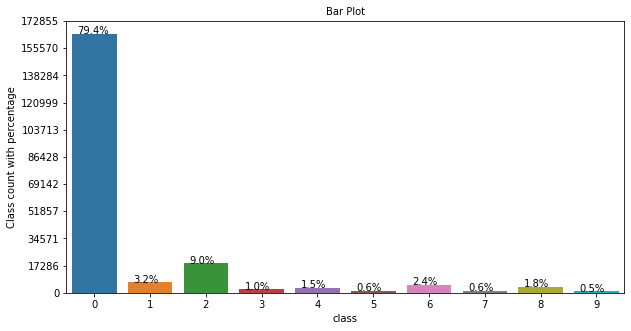

In [15]:
plt.figure(figsize = (10, 5))

ax = sns.countplot(x = "class", data = pavia[["class"]])

for p in ax.patches:
        ax.annotate("{:.1f}%".format(100*p.get_height()/pavia.shape[0]), (p.get_x()+0.1, p.get_height()+5))

        ax.yaxis.set_major_locator(ticker.LinearLocator(11))


plt.xlabel("class", fontsize = 10)
plt.ylabel("Class count with percentage", fontsize = 10)
plt.title("Bar Plot", fontsize = 10)
plt.show()

Enter the band Number(1-104) 45


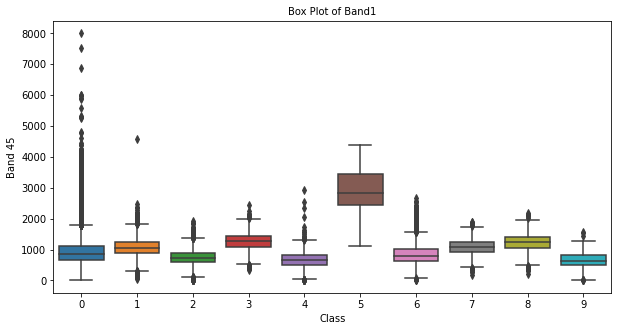

In [16]:
#box plot bands

n = int(input("Enter the band Number(1-104) "))

plt.figure(figsize = (10, 5))
sns.boxplot(x = pavia["class"], y = pavia["band1"]);
plt.title("Box Plot of Band1", fontsize = 10)
plt.xlabel("Class", fontsize = 10)
plt.ylabel(f"Band {n}", fontsize = 10)
plt.show()

In [17]:
#band details
print(f"Details of Band - {n}: \n\n{pavia['band'+str(n)].describe()}")

Details of Band - 45: 

count    207400.000000
mean       1126.066543
std         696.692532
min           0.000000
25%         645.000000
50%        1027.000000
75%        1445.000000
max        8000.000000
Name: band45, dtype: float64


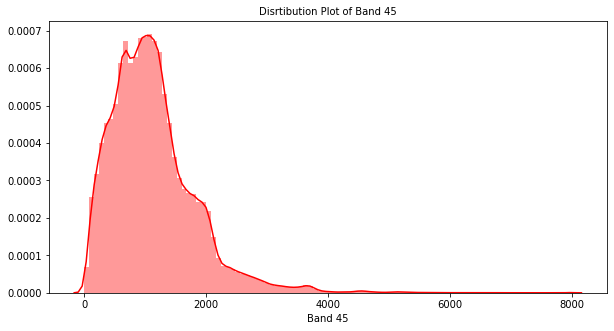

In [18]:
#distribution plot of band

plt.figure(figsize = (10, 5))
sns.distplot(pavia["band"+str(n)], color = "red", bins = 100, hist_kws = {"alpha": 0.4});
plt.xlabel("Band " +str(n), fontsize = 10)
plt.title("Disrtibution Plot of Band " +str(n), fontsize = 10)
plt.show()

In [19]:
#Principal Component Analysis(PCA)

pca = PCA(n_components = 60)

In [20]:
principalComponents = pca.fit_transform(pavia)
ev = pca.explained_variance_ratio_

In [21]:
ev

array([5.83180602e-01, 3.61006927e-01, 4.43756078e-02, 3.00841279e-03,
       2.09792246e-03, 1.77742993e-03, 1.23120974e-03, 6.81949945e-04,
       4.63220133e-04, 3.23406530e-04, 2.45745885e-04, 1.89900695e-04,
       1.45909287e-04, 1.25512483e-04, 9.82157878e-05, 8.63674009e-05,
       7.59131355e-05, 7.33744553e-05, 6.14181541e-05, 5.64319585e-05,
       4.87394492e-05, 4.59359938e-05, 4.26035045e-05, 3.79651391e-05,
       3.58279474e-05, 2.95506808e-05, 2.77158423e-05, 2.65784711e-05,
       2.30335700e-05, 2.13641451e-05, 2.08710507e-05, 1.93700394e-05,
       1.85113494e-05, 1.70945695e-05, 1.60710897e-05, 1.59067225e-05,
       1.49401080e-05, 1.45187403e-05, 1.38574337e-05, 1.25360379e-05,
       1.17623711e-05, 1.11277361e-05, 1.06256117e-05, 1.04029325e-05,
       9.48225611e-06, 9.10444203e-06, 8.64995051e-06, 8.27160469e-06,
       7.84142303e-06, 7.14640658e-06, 7.04744626e-06, 6.45849323e-06,
       5.96111436e-06, 5.33601210e-06, 5.16381354e-06, 4.79423961e-06,
      

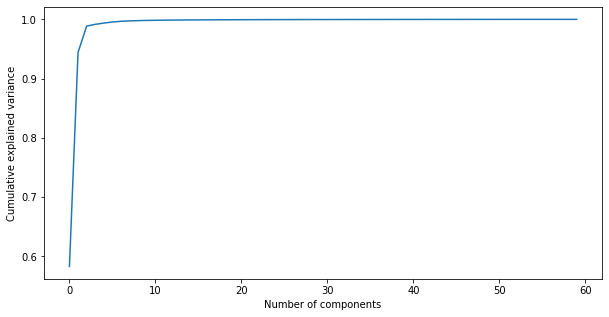

In [22]:
plt.figure(figsize = (10, 5))
plt.plot(np.cumsum(ev))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.show()

In [23]:
#select 30 components for PCA

pca = PCA(n_components = 30)
data = pca.fit_transform(pavia)
pavia_data = pd.concat([pd.DataFrame(data = data), pd.DataFrame(data = y.ravel())], axis = 1)
pavia_data.columns = [f"PC-{i}" for i in range(1,31)] + ["class"]

In [24]:
pavia_data.head()

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,...,PC-22,PC-23,PC-24,PC-25,PC-26,PC-27,PC-28,PC-29,PC-30,class
0,-5150.190065,6795.052773,1532.351413,410.030443,-259.856318,-832.898941,293.239746,278.385218,-285.610038,251.208964,...,-30.373706,30.966693,40.259829,12.862933,36.060902,37.225067,-14.033154,-1.704784,-38.301996,0
1,-6082.245779,3158.592197,1463.194696,154.617406,-438.872022,-496.202146,362.925830,187.355431,-287.796741,180.614477,...,4.713870,25.758845,3.028613,-15.055690,24.346938,-32.646469,-56.183587,-26.386747,19.087002,0
2,-7214.505423,1158.875814,1400.817852,410.044303,38.052804,-560.804231,-140.004209,8.847611,-211.057200,14.139143,...,-14.613804,22.601329,4.181783,42.984919,8.076509,-2.354491,30.522809,-4.683062,-24.912869,0
3,-6566.279379,3398.894765,1126.024727,496.775290,-302.415314,-409.493848,218.391570,-2.957279,-223.380131,188.819661,...,-63.585782,17.660198,-4.072197,-52.906228,38.944282,-11.657077,18.604776,0.715665,-10.966981,0
4,-6496.967988,2154.797773,1035.954529,27.247946,-194.891508,-189.044672,-71.142467,-97.987806,-126.456155,215.181954,...,15.046540,-7.096469,13.757193,31.212069,-73.946052,16.087493,-45.589079,-11.303128,4.646332,0


In [25]:
# saving to .csv
pavia_data.to_csv("Pavia_PCA.csv", index = False)

In [26]:
x = pavia_data[pavia_data["class"] != 0]

X = x.iloc[:, :-1].values

y = x.loc[:, "class"].values 

target_names = ["Asphalt", "Meadows", "Gravel", "Trees", "Painted metal sheets", "Bare Soil", "Bitumen", "Self-Blocking Bricks", "Shadows"]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 11, stratify = y)

In [28]:
#train a linear SVM model 
model = SVC(C = 100, kernel = "rbf", cache_size = 10*1024)

In [29]:
model.fit(X_train, y_train)

SVC(C=100, cache_size=10240)

In [30]:
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(y_train, X_train_prediction)

In [31]:
print("Accuracy score of the training data is: ", training_data_accuracy)

Accuracy score of the training data is:  0.9599238553251177


In [32]:
y_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(y_prediction, y_test)

In [33]:
print("Accuracy score of the test data is: ", test_data_accuracy)

Accuracy score of the test data is:  0.9564404270240785


In [34]:
#classification report
print("Classification Report", classification_report(y_test, y_prediction, target_names = target_names))

Classification Report                       precision    recall  f1-score   support

             Asphalt       0.95      0.96      0.96      1989
             Meadows       0.97      0.98      0.98      5595
              Gravel       0.90      0.84      0.87       630
               Trees       0.97      0.97      0.97       919
Painted metal sheets       1.00      1.00      1.00       403
           Bare Soil       0.95      0.91      0.93      1509
             Bitumen       0.92      0.88      0.90       399
Self-Blocking Bricks       0.90      0.92      0.91      1105
             Shadows       1.00      1.00      1.00       284

            accuracy                           0.96     12833
           macro avg       0.95      0.94      0.95     12833
        weighted avg       0.96      0.96      0.96     12833



<AxesSubplot: xlabel='Predicted_Classes', ylabel='Actual_Classes'>

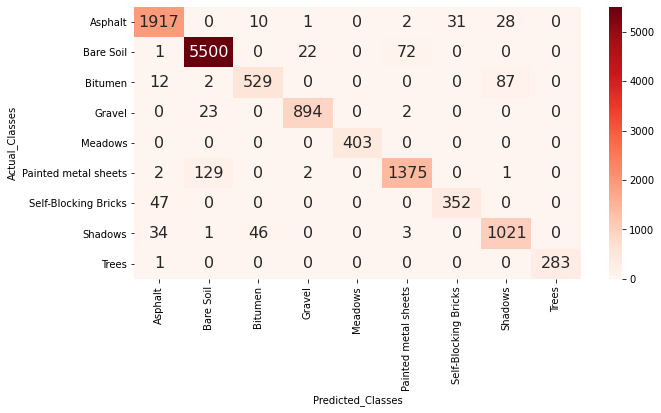

In [35]:
matrix = confusion_matrix(y_test, y_prediction)

cmatrix = pd.DataFrame(matrix, columns = np.unique(target_names), index = np.unique(target_names))

plt.figure(figsize = (10,5))
cmatrix.index.name = "Actual_Classes"
cmatrix.columns.name = "Predicted_Classes"
sns.heatmap(cmatrix, cmap = "Reds", annot = True, annot_kws = {"size": 16}, fmt = "d")

In [36]:
import math
MSE = np.square(np.subtract(y_test,y_prediction)).mean() 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error: \n", RMSE)

Root Mean Square Error: 
 1.002568197544203


In [37]:
print("Mean Absolute Error(MAE):  ", mean_absolute_error(y_test,y_prediction))

Mean Absolute Error(MAE):   6.0300007792410195


In [38]:
l =[]

for i in range(pavia_data.shape[0]):
    if pavia_data.iloc[i, -1] == 0:
        l.append(0)
    else:
        l.append(model.predict(pavia_data.iloc[i, :-1].values.reshape(1, -1)))

<ipython-input-39-8bc40620ec1c>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clmap = np.array(l).reshape(610, 340).astype("float")


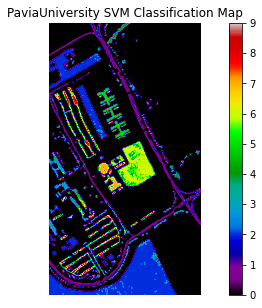

In [39]:
plt.figure(figsize = (10, 5))
clmap = np.array(l).reshape(610, 340).astype("float")
plt.imshow(clmap, cmap = "nipy_spectral")
plt.colorbar()
plt.axis("off")
plt.title("PaviaUniversity SVM Classification Map")
plt.savefig("svm_classification_map.png")
plt.show()